In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [ ]:
#  Load and Inspect Data

df = pd.read_csv("student_depression_dataset.csv")

print(df.head())
print(df.info())
print(df.describe(include='all'))
print("\nMissing values per column:\n", df.isnull().sum())


   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

        Sleep Duration Dietary Habits   Degree  \
0          '5-6 hours'        Healthy  B.Pharm   
1          '5-6 hours'       Moderate      BSc   
2  'Less than 5 hours'        Healthy       BA   
3     

In [ ]:
#  Target/Features Split & Basic Insights

target_col = 'Depression'
target = df[target_col]
features = df.drop([target_col], axis=1)
num_cols = features.select_dtypes(include=[np.number]).columns.tolist()

print("\n===== BASIC INSIGHTS =====")
print(f"Number of students: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print(f"Unique values in target column: {df[target_col].unique()}")
print("\nTarget value counts:\n", target.value_counts())



===== BASIC INSIGHTS =====
Number of students: 27901
Number of features: 18
Unique values in target column: [1 0]

Target value counts:
 Depression
1    16336
0    11565
Name: count, dtype: int64



===== Gender Breakdown =====
 Gender
Male      15547
Female    12354
Name: count, dtype: int64


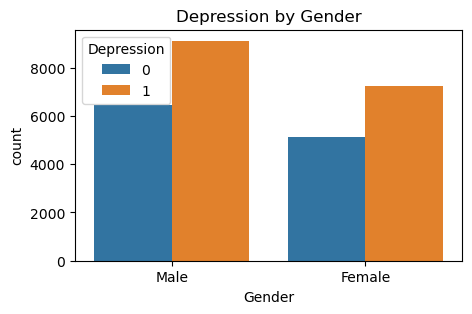

In [5]:
# Gender and other categorical breakdowns if present
if 'Gender' in df.columns:
    print("\n===== Gender Breakdown =====\n", df['Gender'].value_counts())
    plt.figure(figsize=(5,3))
    sns.countplot(x='Gender', data=df, hue=target_col)
    plt.title('Depression by Gender')
    plt.show()


In [6]:
# Group means for key variables
print("\n===== Mean values by Depression =====\n")
print(df.groupby(target_col).mean(numeric_only=True))



===== Mean values by Depression =====

                      id        Age  Academic Pressure  Work Pressure  \
Depression                                                              
0           70397.561089  27.142412           2.361608       0.000605   
1           70473.715536  24.887733           3.693132       0.000306   

                CGPA  Study Satisfaction  Job Satisfaction  Work/Study Hours  
Depression                                                                    
0           7.617282            3.215564          0.000865          6.237959  
1           7.683588            2.751469          0.000551          7.807603  


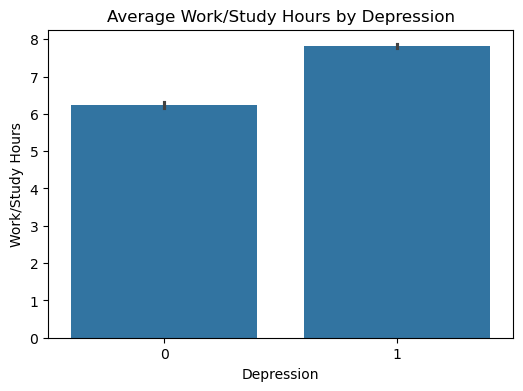

In [7]:
# Bar plot of average study hours (if present) by depression
if 'Work/Study Hours' in df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x=target_col, y='Work/Study Hours', data=df)
    plt.title('Average Work/Study Hours by Depression')
    plt.show()

# EDA Visualizations

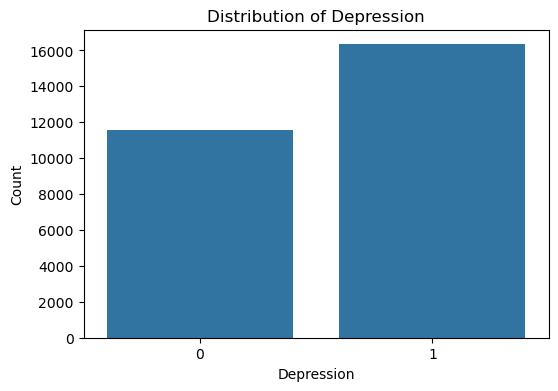

In [8]:
# Visualize target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title('Distribution of Depression')
plt.xlabel('Depression')
plt.ylabel('Count')
plt.show()

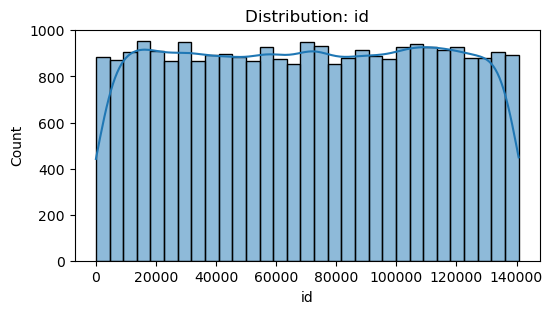

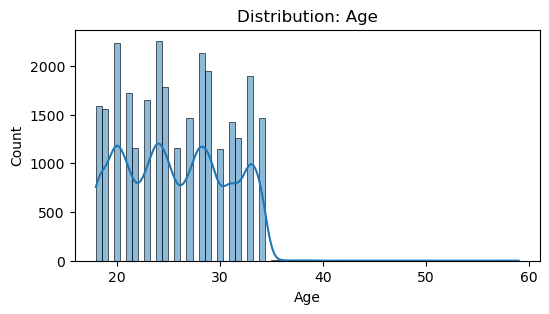

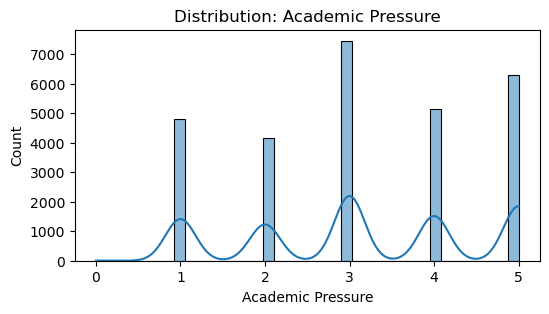

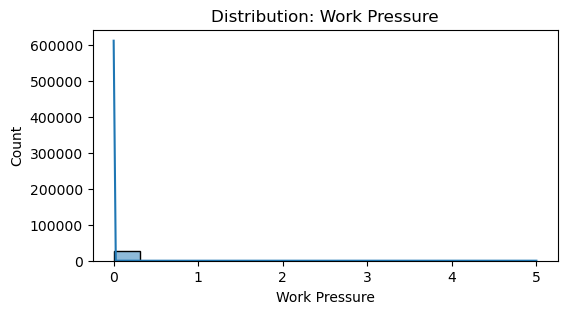

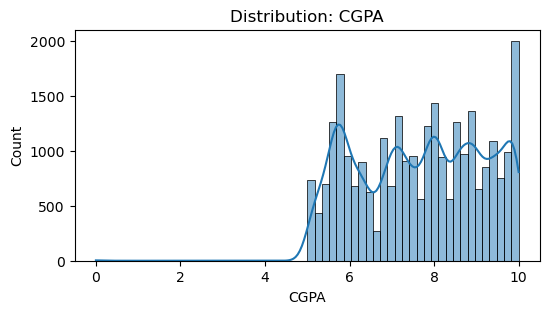

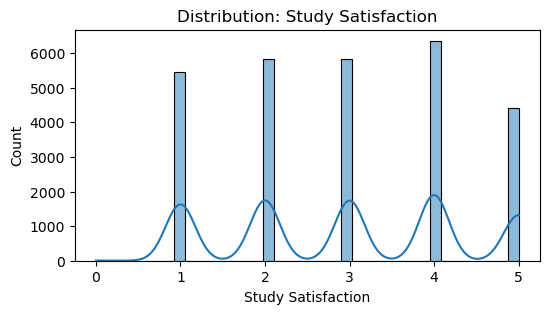

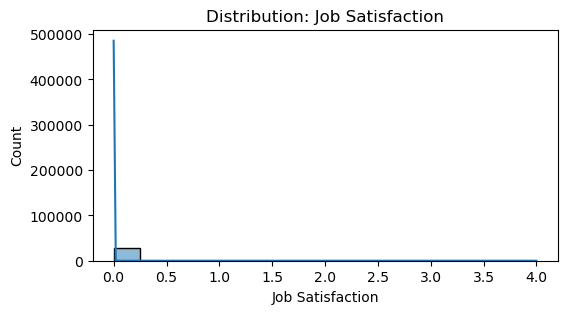

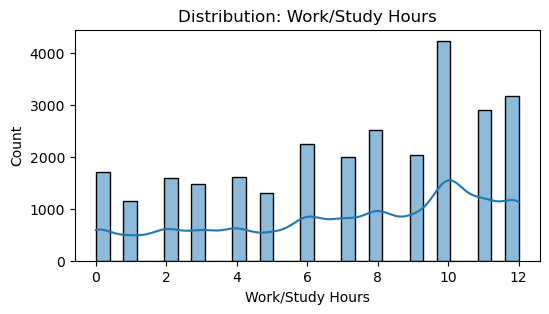

In [9]:
# Histograms for numerical features
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')
    plt.show()

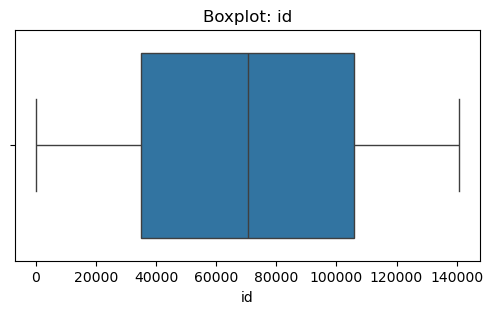

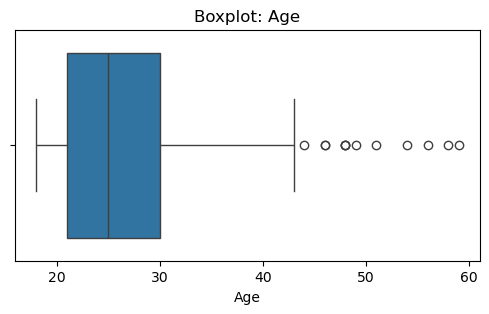

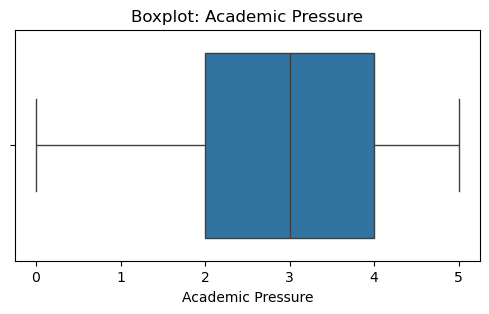

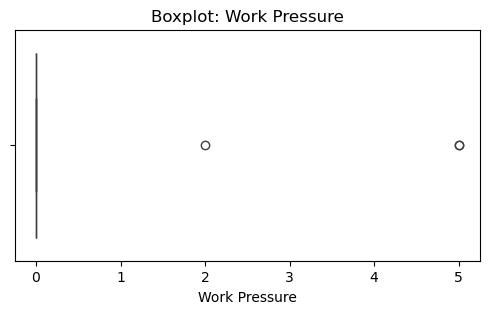

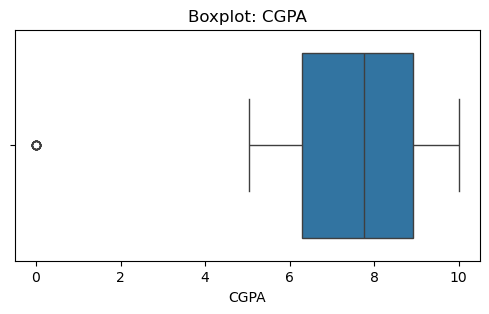

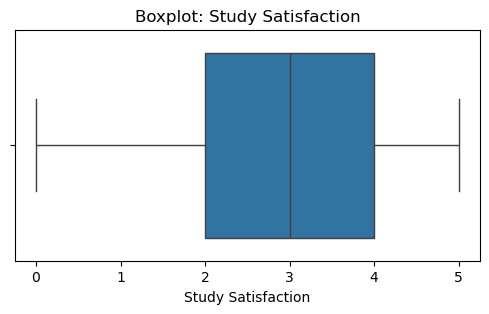

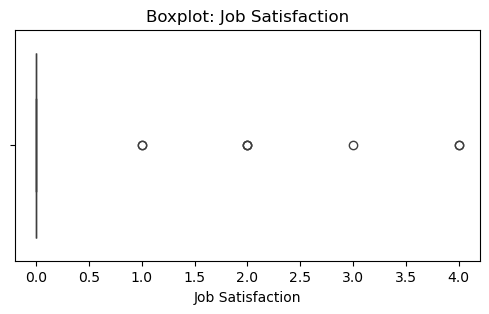

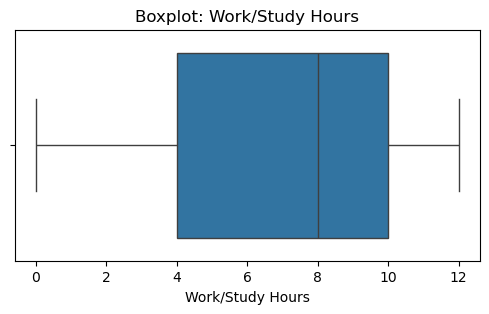

In [10]:
# Boxplots for outlier inspection
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.show()

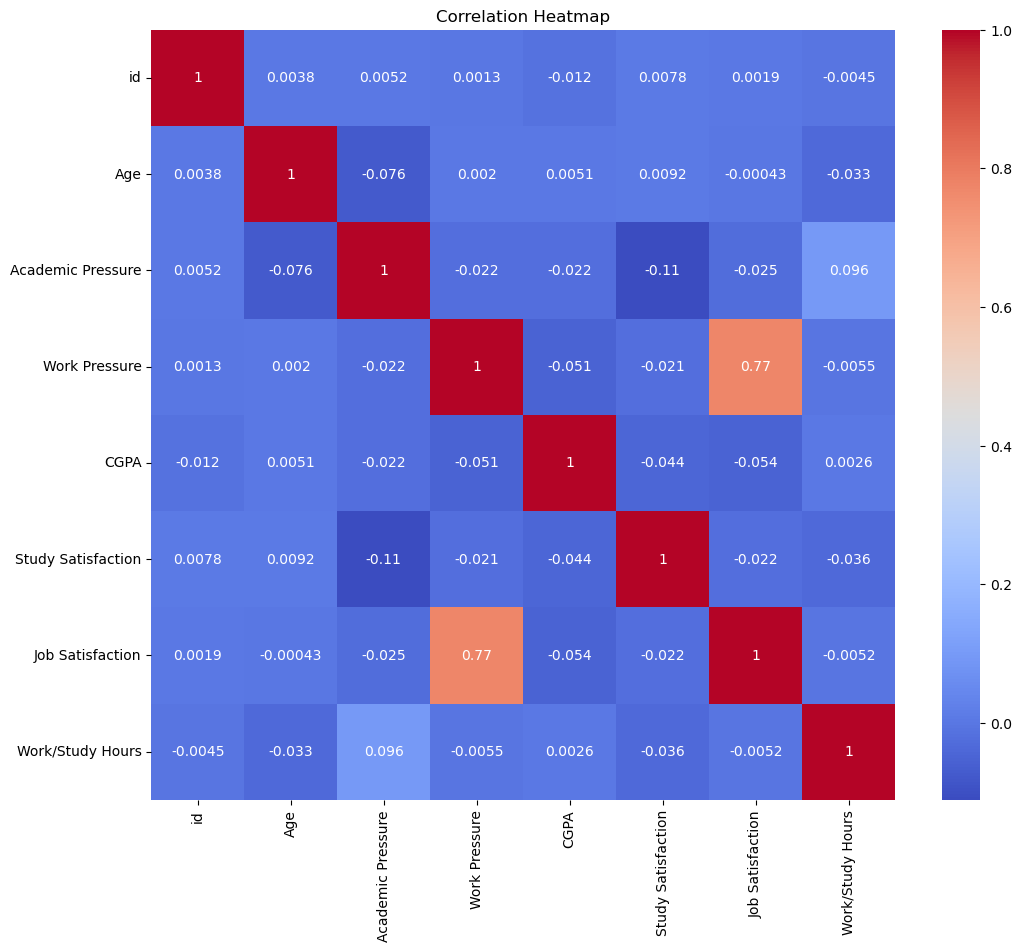

In [11]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# Data Cleaning & Preprocessing

In [ ]:
# Fills missing numerics with median (should be none)
features[num_cols] = features[num_cols].fillna(features[num_cols].median())

# Fills missing categoricals with mode (should be none)
cat_cols = features.select_dtypes(include=['object']).columns
features[cat_cols] = features[cat_cols].fillna(features[cat_cols].mode().iloc[0])

# Encode categorical variables
le = LabelEncoder()
for col in cat_cols:
    features[col] = le.fit_transform(features[col].astype(str))

print("\nAfter encoding, features shape:", features.shape)
print("Sample after encoding:\n", features.head())



After encoding, features shape: (27901, 17)
Sample after encoding:
    id  Gender   Age  City  Profession  Academic Pressure  Work Pressure  CGPA  \
0   2       1  33.0    51          12                5.0            0.0  8.97   
1   8       0  24.0     5          12                2.0            0.0  5.90   
2  26       1  31.0    44          12                3.0            0.0  7.03   
3  30       0  28.0    49          12                3.0            0.0  5.59   
4  32       0  25.0    18          12                4.0            0.0  8.13   

   Study Satisfaction  Job Satisfaction  Sleep Duration  Dietary Habits  \
0                 2.0               0.0               0               0   
1                 5.0               0.0               0               1   
2                 5.0               0.0               2               0   
3                 2.0               0.0               1               1   
4                 3.0               0.0               0              

In [13]:
#  Train/Test Split and Scaling

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42, stratify=target
)
print("Train class balance:\n", y_train.value_counts())
print("Test class balance:\n", y_test.value_counts())


Train class balance:
 Depression
1    13068
0     9252
Name: count, dtype: int64
Test class balance:
 Depression
1    3268
0    2313
Name: count, dtype: int64


# Modeling & Evaluation

In [14]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))



Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      2313
           1       0.86      0.88      0.87      3268

    accuracy                           0.84      5581
   macro avg       0.84      0.84      0.84      5581
weighted avg       0.84      0.84      0.84      5581



In [15]:
# Decision Tree with GridSearchCV
dt_param_grid = {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5)
dt_grid.fit(X_train, y_train)
y_pred_dt = dt_grid.predict(X_test)
print("\nDecision Tree Best Params:", dt_grid.best_params_)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))



Decision Tree Best Params: {'max_depth': 5, 'min_samples_split': 2}
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      2313
           1       0.84      0.86      0.85      3268

    accuracy                           0.82      5581
   macro avg       0.82      0.81      0.81      5581
weighted avg       0.82      0.82      0.82      5581



In [16]:
# Random Forest with GridSearchCV
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_test)
print("\nRandom Forest Best Params:", rf_grid.best_params_)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      2313
           1       0.85      0.88      0.86      3268

    accuracy                           0.84      5581
   macro avg       0.84      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581



In [17]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      2313
           1       0.86      0.88      0.87      3268

    accuracy                           0.85      5581
   macro avg       0.84      0.84      0.84      5581
weighted avg       0.85      0.85      0.85      5581



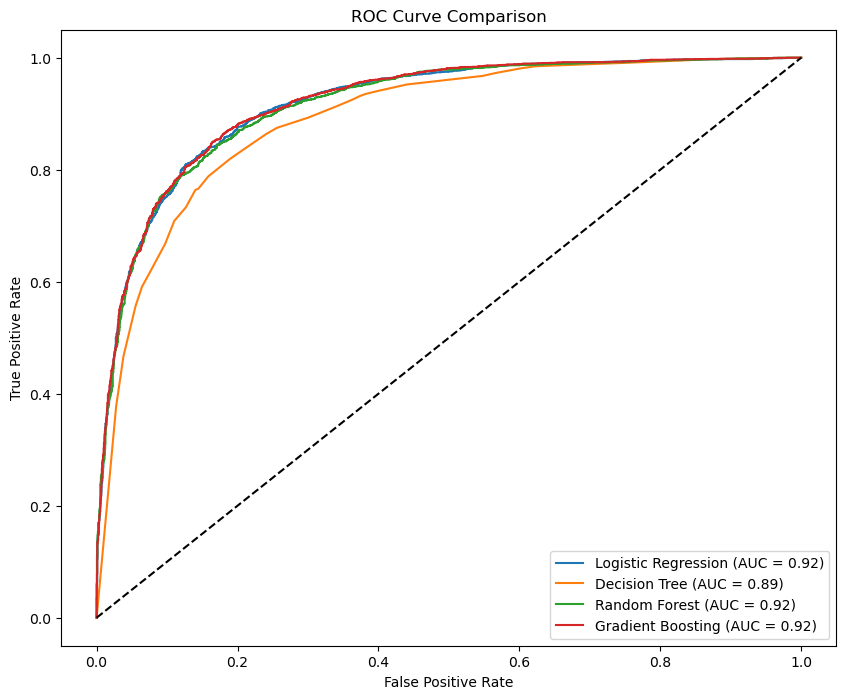

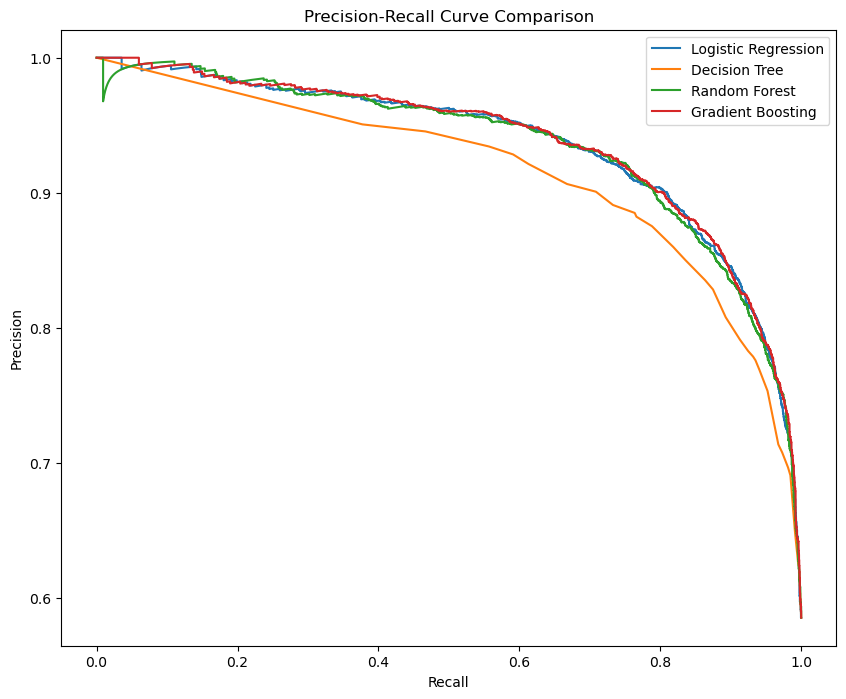

In [18]:
#  ROC and Precision-Recall Curves

plt.figure(figsize=(10, 8))
for model, name in zip([logreg, dt_grid, rf_grid, gb], 
                       ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 8))
for model, name in zip([logreg, dt_grid, rf_grid, gb], 
                       ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall, precision, label=f'{name}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.show()

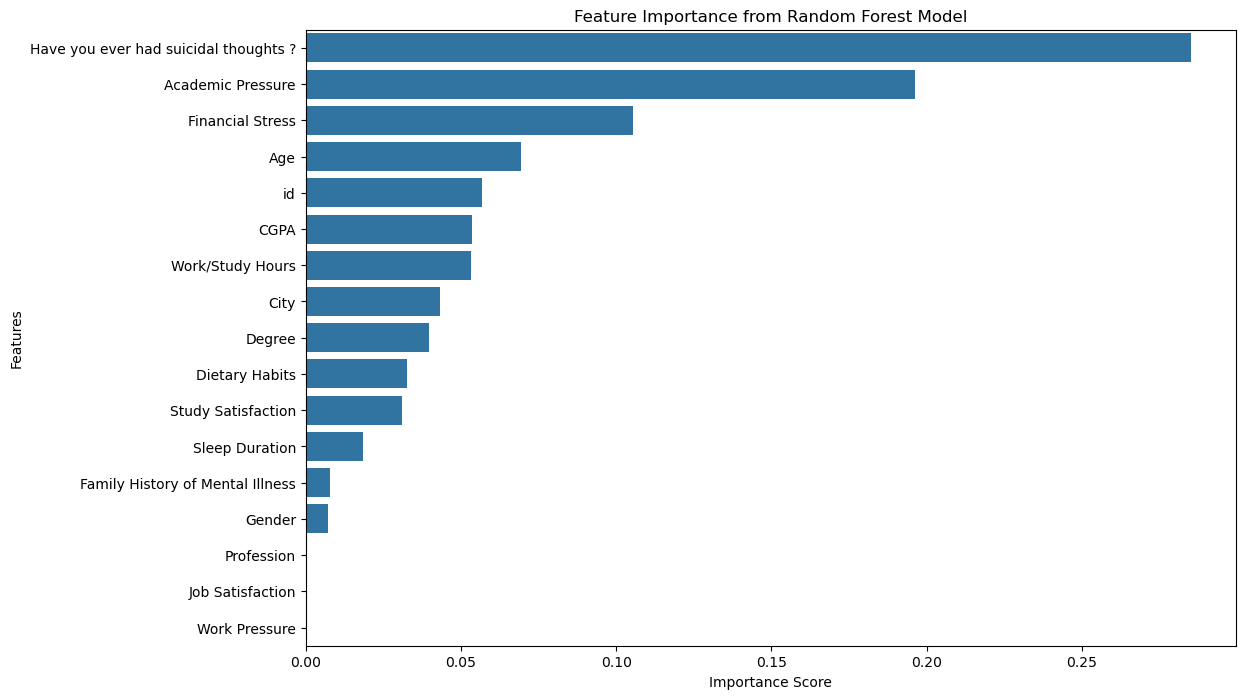

In [19]:
# 9. Feature Importance (Random Forest)

importance = rf_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(12, 8))
sns.barplot(x=importance[indices], y=features.columns[indices])
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


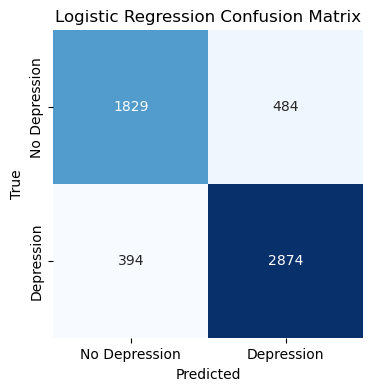

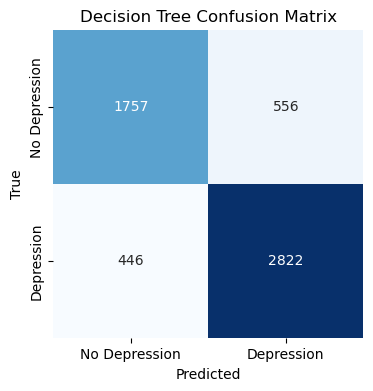

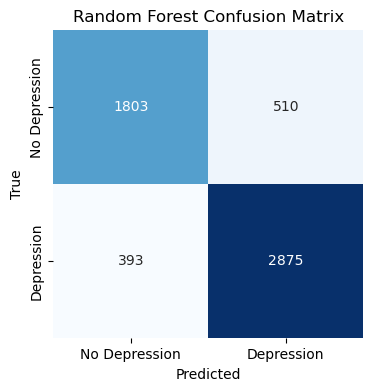

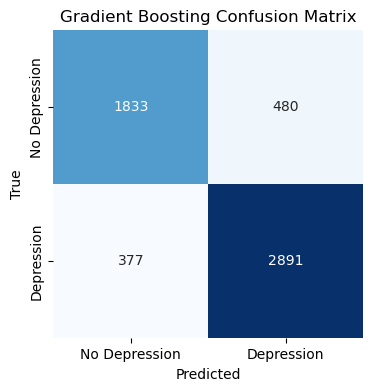

In [20]:
# 10. Confusion Matrices

def plot_cm(cm, classes, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

models = [logreg, dt_grid, rf_grid, gb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
preds = [y_pred_logreg, y_pred_dt, y_pred_rf, y_pred_gb]

for name, model, pred in zip(model_names, models, preds):
    cm = confusion_matrix(y_test, pred)
    plot_cm(cm, classes=['No Depression', 'Depression'], title=f'{name} Confusion Matrix')


In [21]:
# 11. Accuracy Summary

print("\n===== FINAL MODEL COMPARISON (ACCURACY) =====")
for name, pred in zip(model_names, preds):
    print(f"{name}: {accuracy_score(y_test, pred):.3f}")



===== FINAL MODEL COMPARISON (ACCURACY) =====
Logistic Regression: 0.843
Decision Tree: 0.820
Random Forest: 0.838
Gradient Boosting: 0.846


In [ ]:
# Reconstructing the dataframe
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

# Standardize (made sure to keep as DataFrame)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features.columns, index=X_test.index)

# Ensuring X_test_scaled is a DataFrame
# shap_values is a list of two arrays: one for each class
print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(shap_values[1].shape)

<class 'numpy.ndarray'>
5581
(17, 2)
(17, 2)


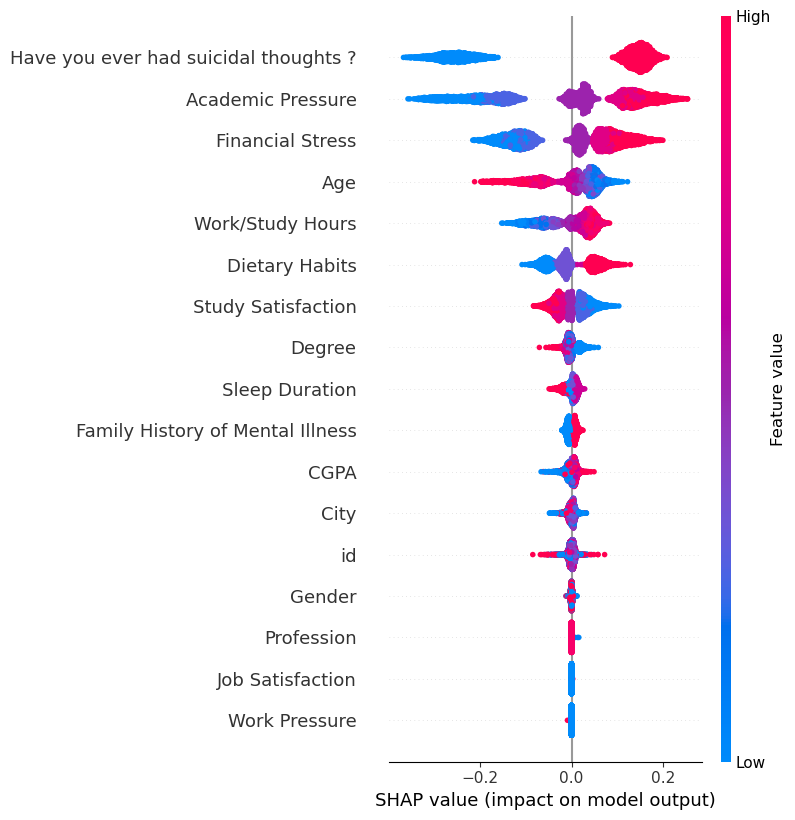

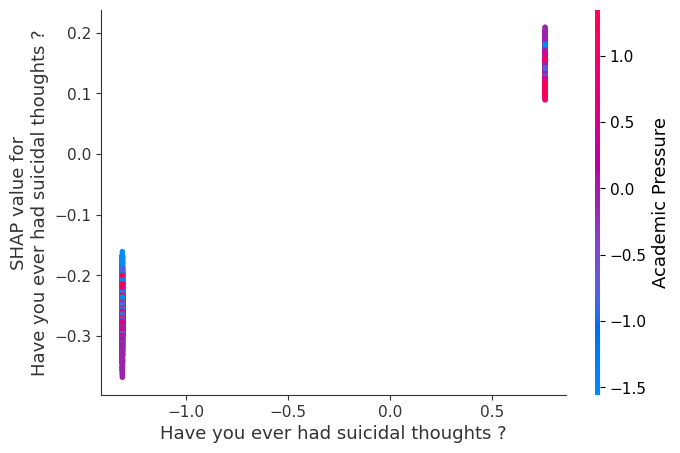

In [31]:
# 12. SHAP Explainability (Random Forest)
import shap

explainer = shap.TreeExplainer(rf_grid.best_estimator_)
shap_values = explainer.shap_values(X_test_scaled)

# If 3D array, take positive class only
if len(shap_values.shape) == 3 and shap_values.shape[2] == 2:
    shap_values_pos = shap_values[:, :, 1]
else:
    shap_values_pos = shap_values

shap.summary_plot(shap_values_pos, X_test_scaled, feature_names=features.columns)

top_feature = features.columns[np.argmax(rf_grid.best_estimator_.feature_importances_)]
shap.dependence_plot(top_feature, shap_values_pos, X_test_scaled, feature_names=features.columns)



# Statistical Tests

In [34]:
from scipy.stats import ttest_ind, chi2_contingency

In [35]:
# T-test: compare mean 'Work/Study Hours' for Depressed vs Not
if 'Work/Study Hours' in df.columns:
    group0 = df[df['Depression'] == 0]['Work/Study Hours']
    group1 = df[df['Depression'] == 1]['Work/Study Hours']
    t_stat, p_val = ttest_ind(group0, group1, nan_policy='omit')
    print(f"\nT-test for Work/Study Hours (Depressed vs Not): t={t_stat:.3f}, p={p_val:.4f}")
    if p_val < 0.05:
        print('Result: Significant difference.')
    else:
        print('Result: No significant difference.')


T-test for Work/Study Hours (Depressed vs Not): t=-35.620, p=0.0000
Result: Significant difference.


In [36]:
# Chi-square: Gender vs Depression
if 'Gender' in df.columns:
    contingency = pd.crosstab(df['Gender'], df['Depression'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"\nChi-square for Gender vs Depression: chi2={chi2:.2f}, p={p:.4f}")
    if p < 0.05:
        print('Result: Significant association.')
    else:
        print('Result: No significant association.')


Chi-square for Gender vs Depression: chi2=0.08, p=0.7737
Result: No significant association.


# Model Export

In [37]:
# 14. Automated EDA Profiling Report (HTML)

# pip install ydata-profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title='Student Depression Dataset Profiling Report', explorative=True)
profile.to_file('student_depression_eda_report.html')
print('Automated EDA report saved as student_depression_eda_report.html')



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 76.86it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Automated EDA report saved as student_depression_eda_report.html


In [38]:
import joblib
joblib.dump(rf_grid.best_estimator_, 'student_depression_rf_model.joblib')
print('Random Forest model saved as student_depression_rf_model.joblib')

Random Forest model saved as student_depression_rf_model.joblib


In [ ]:
# 16. Data Dictionary & Group Summary

# Converts known numeric-looking columns to float
for col in ['Financial Stress']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Numeric summary by Depression group
numeric_cols = df.select_dtypes(include=[np.number]).columns
group_summary = df.groupby(target_col)[numeric_cols].agg(['mean', 'std', 'count'])
print('\nSummary stats by Depression:\n', group_summary)
group_summary.to_csv('depression_group_summary.csv')
print('Group summary saved as depression_group_summary.csv')

# Data dictionary
print('\nDATA DICTIONARY:')
for col in df.columns:
    print(f"{col}: {df[col].dtype}, unique: {df[col].nunique()}, sample: {df[col].unique()[:3]}")

# Showing value counts for categoricals by group
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nValue counts of '{col}' by {target_col}:")
    print(df.groupby(target_col)[col].value_counts())




Summary stats by Depression:
                       id                             Age                   \
                    mean           std  count       mean       std  count   
Depression                                                                  
0           70397.561089  40556.248313  11565  27.142412  4.943370  11565   
1           70473.715536  40702.402805  16336  24.887733  4.658028  16336   

           Academic Pressure                  Work Pressure  ...  \
                        mean       std  count          mean  ...   
Depression                                                   ...   
0                   2.361608  1.252937  11565      0.000605  ...   
1                   3.693132  1.188834  16336      0.000306  ...   

           Job Satisfaction Work/Study Hours                   \
                      count             mean       std  count   
Depression                                                      
0                     11565         6.237959  3